# Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Show gray scale image and it's corresponding gray scale value distribution

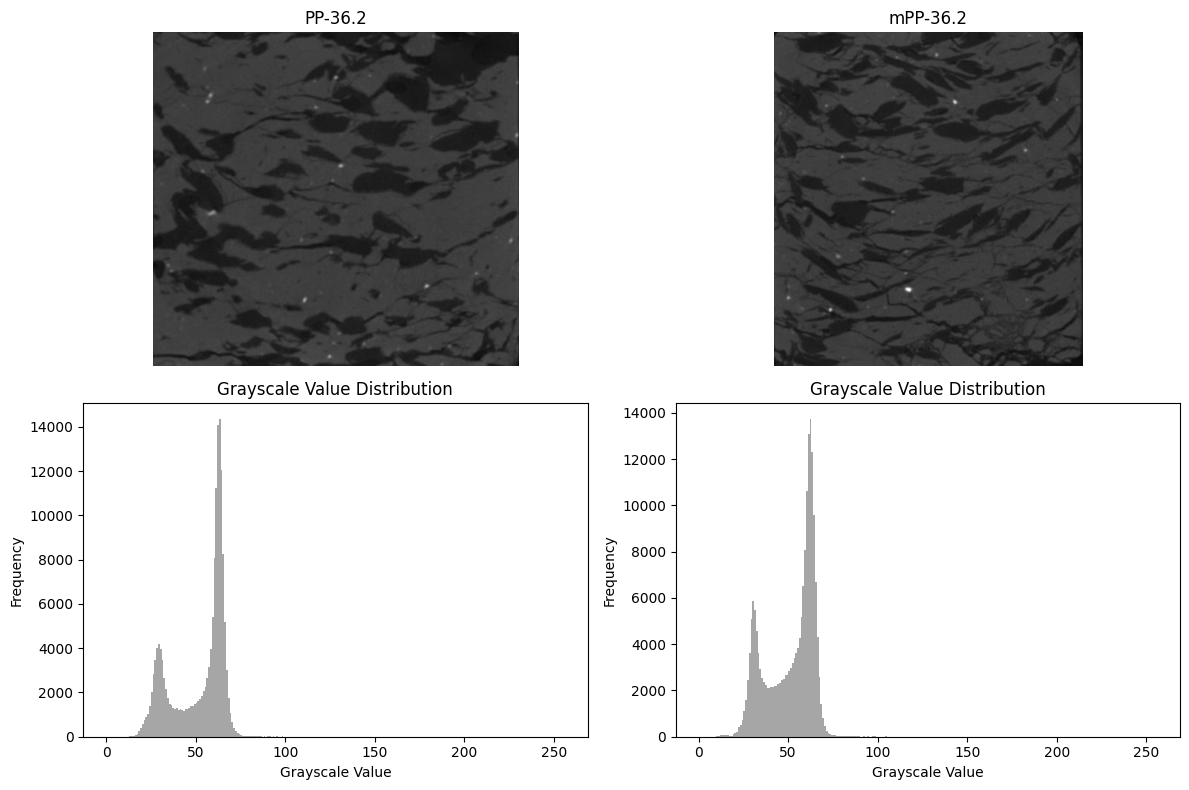

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_grayscale_distribution(ax, image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Flatten the grayscale image to a 1D array
    flattened_image = gray_image.ravel()

    # Plot the grayscale value distribution
    ax.hist(flattened_image, bins=256, range=(0, 256), color='gray', alpha=0.7)
    ax.set_xlabel('Grayscale Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Grayscale Value Distribution')

# Replace 'path_to_your_image.jpg' with the actual paths of your image files
image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/test/IPP15_10.jpg',
    '/content/drive/MyDrive/Colab Notebooks/test/MIPP15_2.jpg'
]

# Create a figure with two rows and two columns
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Load and display the first image
image1 = cv2.imread(image_paths[0])
axs[0, 0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('PP-36.2')
axs[0, 0].axis('off')

# Load and display the second image
image2 = cv2.imread(image_paths[1])
axs[0, 1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('mPP-36.2')
axs[0, 1].axis('off')

# Plot the grayscale value distribution for the first image
plot_grayscale_distribution(axs[1, 0], image1)

# Plot the grayscale value distribution for the second image
plot_grayscale_distribution(axs[1, 1], image2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()



# Create Class to do fitting and plot the false color image that shows the Interphase between polymer and ceramic in the composite

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors

class ImageHistogramPlotter:
    def __init__(self, image_path, sample_name='Test', fit_func_1="gaussian", fit_func_2="gaussian"):
        self.image_path = image_path
        self.data_below, self.data_above, self.peak_index_below, self.peak_index_above = self.split_data(image_path)
        self.initial_guess1 = [100, self.peak_index_below, 2]
        self.initial_guess2 = [100, self.peak_index_above, 2]
        self.mean1 = None
        self.std_dev1 = None
        self.mean2 = None
        self.std_dev2 = None
        self.amp1 = None
        self.amp2 = None
        self.plot_name = sample_name
        self.fun_1 = fit_func_1
        self.fun_2 = fit_func_2
        self.fit_1(self.data_below)
        self.fit_2(self.data_above)

    def fit_1(self, data):
        # Calculate the histogram of data
        hist, bins = np.histogram(data, bins=256, range=(0, 256), density=False)
        x_values = np.arange(256)
        bin_width = 1
        # Find the peak index
        peak_index = np.argmax(hist)
        mirrored_data = np.concatenate((hist[:peak_index+1], hist[:peak_index+1][::-1]))
        if mirrored_data.size > 256:
            mirrored_data = mirrored_data[:256]
            mirrored_x = x_values
        else:
            mirrored_x = x_values[:mirrored_data.size]

        def gaussian(x, amplitude, mean, std_dev):
            return amplitude * np.exp(-0.5 * ((x - mean) / std_dev)**2)

        def lorentz(x, amplitude, center, gamma):
            return amplitude * (1 / np.pi) * (gamma / ((x - center)**2 + gamma**2))

        if self.fun_1 == "gaussian":
        # Fit the Gaussian to the data
            params, _ = curve_fit(gaussian, mirrored_x, mirrored_data * bin_width, self.initial_guess1)
            # Extract mean and standard deviation
            self.amp1, self.mean1, self.std_dev1 = params[0], params[1], abs(params[2])

        elif self.fun_1 == "lorentz":
            params, _ = curve_fit(lorentz, mirrored_x, mirrored_data * bin_width, self.initial_guess1)
            self.amp1, self.mean1, self.std_dev1 = params[0], params[1], abs(params[2])
        else:
            print("Fitting function is not available!, Fitting was used default gaussian function.")
            params, _ = curve_fit(gaussian, mirrored_x, mirrored_data * bin_width, self.initial_guess1)
            self.amp1, self.mean1, self.std_dev1 = params[0], params[1], abs(params[2])

    def fit_2(self, data):
        # Calculate the histogram of data
        hist, bins = np.histogram(data, bins=256, range=(0, 256), density=False)
        x_values = np.arange(256)
        bin_width = 1
        # Find the peak index
        peak_index = np.argmax(hist)
        mirrored_data = np.concatenate((hist[peak_index:][::-1],hist[peak_index:]))

        if mirrored_data.size > 256:
            mirrored_data = mirrored_data[mirrored_data.size-256:]
            mirrored_x = x_values
        else:
            mirrored_x = x_values[peak_index-mirrored_data.size//2:peak_index+mirrored_data.size//2]

        # Define a Gaussian function with parameters: x (input), amplitude, mean, and standard deviation
        def gaussian(x, amplitude, mean, std_dev):
            return amplitude * np.exp(-0.5 * ((x - mean) / std_dev)**2)

        def lorentz(x, amplitude, center, gamma):
            return amplitude * (1 / np.pi) * (gamma / ((x - center)**2 + gamma**2))

        if self.fun_2 == "gaussian":
        # Fit the Gaussian to the data
            params, _ = curve_fit(gaussian, mirrored_x, mirrored_data * bin_width, self.initial_guess2)
            # Extract mean and standard deviation
            self.amp2, self.mean2, self.std_dev2 = params[0], params[1], abs(params[2])

        elif self.fun_2 == "lorentz":
            params, _ = curve_fit(lorentz, mirrored_x, mirrored_data * bin_width, self.initial_guess2)
            self.amp2, self.mean2, self.std_dev2 = params[0], params[1], abs(params[2])
        else:
            print("Fitting function is not available!, Fitting was used default gaussian function.")
            params, _ = curve_fit(gaussian, mirrored_x, mirrored_data * bin_width, self.initial_guess2)
            self.amp2, self.mean2, self.std_dev2 = params[0], params[1], abs(params[2])

    def plot_histogram(self):
        x_values = np.arange(256)
        bin_width = 1

        # Create the fitted Gaussian and Lorentzian curves
        if self.fun_1 =='gaussian':
            curve_1 = self.amp1 * np.exp(-0.5 * ((x_values - self.mean1) / self.std_dev1)**2)
        elif self.fun_1 =='lorentz':
            curve_1 = self.amp1 * (1 / np.pi) * (self.std_dev1 / ((x_values - self.mean1)**2 + self.std_dev1**2))
        else:
            print('Fitting function is not available! Plot was used default gaussian function.')
            curve_1 = self.amp1 * np.exp(-0.5 * ((x_values - self.mean1) / self.std_dev1)**2)

        if self.fun_2 =='gaussian':
            curve_2 = self.amp2 * np.exp(-0.5 * ((x_values - self.mean2) / self.std_dev2)**2)
        elif self.fun_2 =='lorentz':
            curve_2 = self.amp2 * (1 / np.pi) * (self.std_dev2 / ((x_values - self.mean2)**2 + self.std_dev2**2))
        else:
            print('Fitting function is not available! Plot was used default gaussian function.')
            curve_2 = self.amp2 * np.exp(-0.5 * ((x_values - self.mean2) / self.std_dev2)**2)

        # Plot the histograms, Gaussian, and Lorentzian curves
        plt.figure(figsize=(6.6, 4.08))

        plt.hist(self.data_below, bins=256, range=(0, 256), color='gray', alpha=0.7, density=False)
        plt.hist(self.data_above, bins=256, range=(0, 256), color='gray', alpha=0.7, density=False)

        plt.plot(x_values, curve_1 / bin_width, 'r-', label=f'Fit1 ({self.fun_1})')
        plt.plot(x_values, curve_2 / bin_width, 'g-', label=f'Fit2 ({self.fun_2})')

        plt.xlabel('Grayscale Value')
        plt.ylabel('Frequency')
        plt.title(self.plot_name)
        # plt.xlim(0, 120)
        plt.legend()

        plt.show()

    def plot_histogram_with_residuals(self):
        # Calculate the histograms for the Gaussian and Lorentzian fits
        hist_below, bins_below = np.histogram(self.data_below, bins=256, range=(0, 256), density=False)
        hist_above, bins_above = np.histogram(self.data_above, bins=256, range=(0, 256), density=False)
        x_values = np.arange(256)
        bin_width = 1

        # Create the fitted Gaussian and Lorentzian curves
        if self.fun_1 == 'gaussian':
            curve_1 = self.amp1 * np.exp(-0.5 * ((x_values - self.mean1) / self.std_dev1)**2)
        elif self.fun_1 == 'lorentz':
            curve_1 = self.amp1 * (1 / np.pi) * (self.std_dev1 / ((x_values - self.mean1)**2 + self.std_dev1**2))
        else:
            print('Fitting function is not available! Plot was used the default Gaussian function.')
            curve_1 = self.amp1 * np.exp(-0.5 * ((x_values - self.mean1) / self.std_dev1)**2)

        if self.fun_2 == 'gaussian':
            curve_2 = self.amp2 * np.exp(-0.5 * ((x_values - self.mean2) / self.std_dev2)**2)
        elif self.fun_2 == 'lorentz':
            curve_2 = self.amp2 * (1 / np.pi) * (self.std_dev2 / ((x_values - self.mean2)**2 + self.std_dev2**2))
        else:
            print('Fitting function is not available! Plot was used the default Gaussian function.')
            curve_2 = self.amp2 * np.exp(-0.5 * ((x_values - self.mean2) / self.std_dev2)**2)

        # Calculate the residuals
        max_value = max(hist_below.max(),hist_above.max())
        residuals_1 = (hist_below - curve_1)/max_value
        residuals_2 = (hist_above - curve_2)/max_value

        # Create a figure with two subplots (histograms and residuals)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.6, 8.16))

        # Plot the histograms and fitted curves
        ax1.hist(self.data_below, bins=256, range=(0, 256), color='gray', alpha=0.7, density=False)
        ax1.hist(self.data_above, bins=256, range=(0, 256), color='gray', alpha=0.7, density=False)
        ax1.plot(x_values, curve_1 / bin_width, 'r-', label=f'Fit1 ({self.fun_1})')
        ax1.plot(x_values, curve_2 / bin_width, 'g-', label=f'Fit2 ({self.fun_2})')
        ax1.set_xlabel('Grayscale Value')
        ax1.set_ylabel('Frequency')
        ax1.set_title(self.plot_name)
        # ax1.set_xlim(0, 120)
        ax1.legend()

        # Plot the residuals
        ax2.plot(x_values, residuals_1, 'r-', label='Residuals 1')
        ax2.plot(x_values, residuals_2, 'g-', label='Residuals 2')
        ax2.axhline(y=0, color='k', linestyle='--', linewidth=1,label='Reference')
        ax2.set_xlabel('Grayscale Value')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residuals')
        # ax2.set_xlim(0, 120)
        ax2.set_ylim(-1, 1)
        ax2.legend()

        plt.tight_layout()
        plt.show()


    def calculate_phase_percentages(self, factor_of_std=2):
        image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
        data = image.flatten()
        # Calculate the intermediate phase range based on your criteria
        intermediate_min = self.mean1 + factor_of_std * (self.std_dev1)
        intermediate_max = self.mean2 - factor_of_std * (self.std_dev2)

        # Calculate the percentages of each phase
        total_pixels = data.size
        intermediate_phase_pixels = np.sum((data >= intermediate_min) & (data <= intermediate_max))
        first_material_pixels = np.sum(data < intermediate_min)
        second_material_pixels = np.sum(data > intermediate_max)

        # Calculate the percentages
        intermediate_phase_percentage = (intermediate_phase_pixels / total_pixels) * 100
        first_material_percentage = (first_material_pixels / total_pixels) * 100
        second_material_percentage = (second_material_pixels / total_pixels) * 100

        return intermediate_phase_percentage,first_material_percentage,second_material_percentage

    def generate_false_color_image(self, colormap="viridis", factor_of_std=2):
        image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)

        intermediate_min = self.mean1 + factor_of_std * (self.std_dev1)
        intermediate_max = self.mean2 - factor_of_std * (self.std_dev2)

        def map_intermediate_phase(value):
            if value < intermediate_min:
                return intermediate_min-1  # Set to the minimum intermediate value
            elif value > intermediate_max:
                return intermediate_max+1  # Set to the maximum intermediate value
            else:
                return value


        # Create a colormap instance
        cmap = plt.get_cmap(colormap)

        # Apply the mapping function element-wise to the entire image array
        mapped_image = np.vectorize(map_intermediate_phase)(image)
        # Apply the colormap to the grayscale image, but use intermediate_min and intermediate_max as the colormap range
        normalized_image = (mapped_image - intermediate_min+1) / (intermediate_max - intermediate_min+2)
        false_color_image = cmap(normalized_image)

        # # Display the colorbar with numeric values
        # norm = mcolors.Normalize(vmin=intermediate_min, vmax=intermediate_max)
        # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])
        # cbar = plt.colorbar(sm)
        # cbar.set_label('Intermediate phase (gray scale value)')

        # # Display the colorbar without numeric values
        fig, ax = plt.subplots()
        cbar = fig.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=intermediate_min, vmax=intermediate_max)), ax=ax)

        # Set the labels for the color bar
        cbar.set_label('Interphase', fontsize=14)
        cbar.set_ticks([])  # Remove numeric ticks
        # Reverse the colorbar display
        cbar.ax.invert_yaxis()
        cbar.ax.text(1.2, intermediate_min +0.7, 'Polymer',fontsize=14)
        cbar.ax.text(1.2, intermediate_max +0.1, 'CaSO$\\mathregular{_4}$',fontsize=14)


        return false_color_image

    def split_data(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Define Otsu's threshold to separate data into two parts
        th_v, threshold_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Split the data based on the threshold
        data_below_threshold = image[threshold_image <= th_v].flatten()
        data_above_threshold = image[threshold_image > th_v].flatten()

        peak_index_below = np.argmax(np.histogram(data_below_threshold, bins=256, range=(0, 256))[0])
        peak_index_above = np.argmax(np.histogram(data_above_threshold, bins=256, range=(0, 256))[0])

        return data_below_threshold, data_above_threshold, peak_index_below, peak_index_above


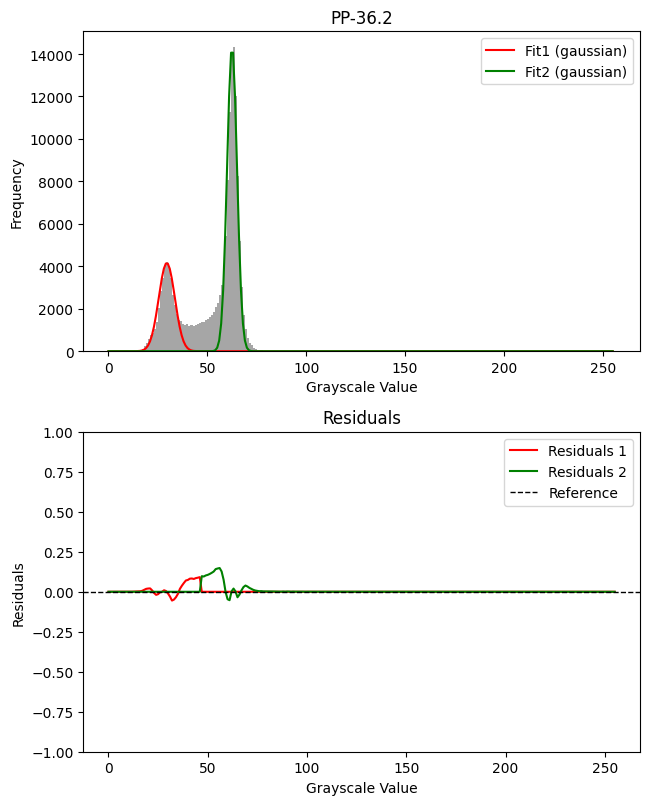

19.709942551966584 24.684893249549848 55.60516419848357


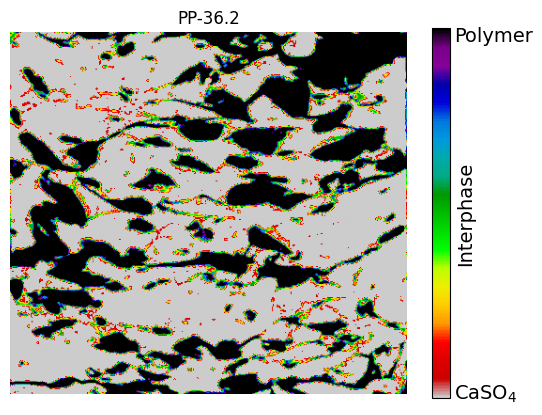

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/test/IPP15_10.jpg'

plotter = ImageHistogramPlotter(image_path, sample_name='PP-36.2',fit_func_1="gaussian", fit_func_2="gaussian")

# Plot histogram and fitted curves
plotter.plot_histogram_with_residuals()

# Calculate phase percentages
im,first,second = plotter.calculate_phase_percentages(factor_of_std=2)
print(im,first,second)

false_color_image = plotter.generate_false_color_image(colormap='nipy_spectral',factor_of_std=2)
plt.imshow(false_color_image)
plt.axis('off')
plt.title('PP-36.2')
plt.show()

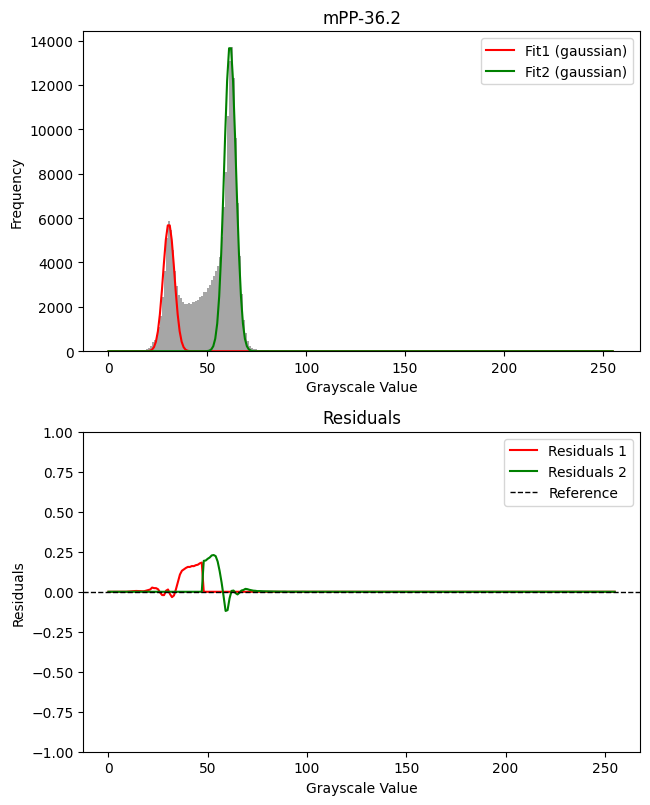

25.655136268343814 22.534118469190613 51.81074526246557


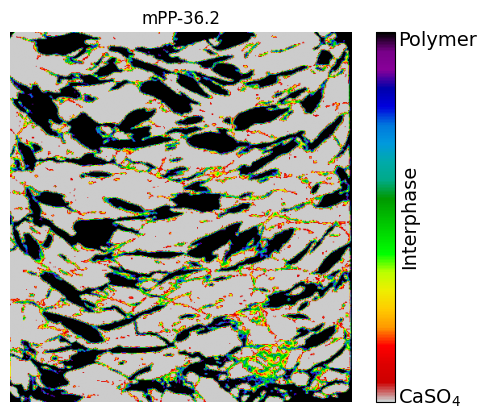

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/test/MIPP15_2.jpg'
plotter = ImageHistogramPlotter(image_path, sample_name='mPP-36.2',fit_func_1="gaussian", fit_func_2="gaussian")

# Plot histogram and fitted curves
# plotter.plot_histogram()
plotter.plot_histogram_with_residuals()

# Calculate phase percentages
im,first,second = plotter.calculate_phase_percentages(factor_of_std=2)
print(im,first,second)

false_color_image = plotter.generate_false_color_image(colormap='nipy_spectral',factor_of_std=2)
plt.imshow(false_color_image)
plt.axis('off')
plt.title('mPP-36.2')
plt.show()

# Calculate domain thickness in two methods. One is orignal based on Ostu's binary method and the othe one is based on the gaussian fitting to differentiate polymer and ceramic. Threshold value for second method is based on ceramic domain fitting mean-2*std

In [54]:
import cv2
import numpy as np
import os
import csv
import pandas as pd
from itertools import chain

# Function for analyze one image domain thickness
def one_image_thickness(img, thresh_value):
    # Get the dimensions of the image
    height, width = img.shape
    avg_white_pixels = []
    for w in range(width):
        white_pixels = []
        for h in range(height):
            if img[h,w] > thresh_value:
                white_pixels.append(h)
        if len(white_pixels) > 0:
            white_pixels = np.array(white_pixels)
            diff = np.diff(white_pixels)
            continuous = np.where(diff > 1)[0]
            if len(continuous) > 0:
                segments = np.split(white_pixels, continuous + 1)
                lengths = [len(segment) for segment in segments]
                avg_white_pixels.append(sum(lengths) / len(lengths))
            else:
                avg_white_pixels.append(len(white_pixels))
        else:
            avg_white_pixels.append(0)
    return avg_white_pixels

def calculate_thickness(input_dirs, final_csv_saving_path, pixel_size=7.5, factor_of_std=2):
    subfolder_data = []
    i = 1

    for input_dir in input_dirs:
        all_data_1 = {}  # To store all_white_pixels_1 data for each subfolder
        all_data_2 = {}  # To store all_white_pixels_2 data for each subfolder
        print(f'Runnning {i} of {len(input_dirs)} folders')
        print(f'Now working on {input_dir}...............')
         # Define the output directory as the same as input directory
        output_dir = input_dir


        # Define the output CSV file name as the same as the input directory name
        output_file = os.path.join(output_dir, os.path.basename(input_dir) + '_thickness_analysis.csv')
        # Initialize the output CSV file
        with open(output_file, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Image Name', 'Average Thickness(µm)_1', 'Standard Deviation of Thickness_1',
                             'Average Thickness(µm)_2', 'Standard Deviation of Thickness_2','fitting1_mean', 'fitting1_std', 'fitting2_mean', 'fitting2_std',
                             'Interphase(%)', 'First Material(%)','Second Material(%)'])

        # Initialize lists to accumulate thickness values for all images in the subfolder
        all_white_pixels_1 = []
        all_white_pixels_2 = []

        # Loop over all the images in the input directory
        for filename in os.listdir(input_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                # Load the binary image
                img_path = os.path.join(input_dir, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                # print(filename)

                # Define Otsu's threshold to separate data into two parts
                th_v, threshold_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                # Create an instance of the ImageHistogramPlotter class
                plotter = ImageHistogramPlotter(img_path, sample_name=filename, fit_func_1="gaussian", fit_func_2="gaussian")

                # Calculate phase percentages
                im,first,second = plotter.calculate_phase_percentages(factor_of_std = factor_of_std)

                # Scan each width position and compute the average continuous white pixels
                intermediate_max = plotter.mean2 - factor_of_std * (plotter.std_dev2)
                avg_white_pixels_1 = one_image_thickness(img, th_v)
                avg_white_pixels_2 = one_image_thickness(img, intermediate_max)

                # Compute the average and standard deviation of the average continuous white pixels
                avg1 = np.mean(avg_white_pixels_1)
                std1 = np.std(avg_white_pixels_1)
                avg_thickness_1 = avg1 * pixel_size
                std_thickness_1 = std1 * pixel_size
                avg2 = np.mean(avg_white_pixels_2)
                std2 = np.std(avg_white_pixels_2)
                avg_thickness_2 = avg2 * pixel_size
                std_thickness_2 = std2 * pixel_size

                # Calculate the average thickness for the current image and append to the list
                all_white_pixels_1.append(avg_white_pixels_1)
                all_white_pixels_2.append(avg_white_pixels_2)


                # Append the data to the output CSV file
                with open(output_file, 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([filename, avg_thickness_1, std_thickness_1, avg_thickness_2, std_thickness_2,
                                     plotter.mean1, plotter.std_dev1, plotter.mean2, plotter.std_dev2, im, first, second])

        # Calculate the average thickness for all images within the subfolder
        lst1 = [item for sublist in all_white_pixels_1 for item in sublist]
        lst2 = [item for sublist in all_white_pixels_2 for item in sublist]

        # Store the data for this subfolder in the dictionaries
        all_data_1[input_dir] = [pixel_size * value for value in lst1]
        all_data_2[input_dir] = [pixel_size * value for value in lst2]

        # Create DataFrames
        df1 = pd.DataFrame(all_data_1)
        df2 = pd.DataFrame(all_data_2)
        # Define the output CSV file name as the same as the input directory name
        df1_output_file = os.path.join(output_dir, os.path.basename(input_dir) + '_all_thickness_row_data1.csv')
        df2_output_file = os.path.join(output_dir, os.path.basename(input_dir) + '_all_thickness_row_data2.csv')

        # Save df1 and df2 as CSV in the same directory as the input subfolder
        df1.to_csv(df1_output_file, index=False)
        df2.to_csv(df2_output_file, index=False)

        avg_thickness_subfolder_1 = np.mean(lst1) * pixel_size
        std_of_subfolder_1 = np.std(lst1)* pixel_size

        avg_thickness_subfolder_2 = np.mean(lst2) * pixel_size
        std_of_subfolder_2 = np.std(lst2)* pixel_size

        folder_name = os.path.basename(os.path.normpath(input_dir))
        uts_value = folder_name.split('_')[-3]
        elongation = float(folder_name.split('_')[-1])
        ym = float(folder_name.split('_')[-2])

        subfolder_data.append({
            'Subfolder Name': os.path.basename(input_dir),
            'UTS(MPa)': uts_value,
            'Average Thickness(µm)_1': avg_thickness_subfolder_1,
            'STD of avg thickness(µm)_1': std_of_subfolder_1,

            'Average Thickness(µm)_2': avg_thickness_subfolder_2,
            'STD of avg thickness(µm)_2': std_of_subfolder_2,

            'Elongation(%)': elongation,
            'YM(GPa)': ym
        })

        i += 1

    root_output_file = os.path.join(final_csv_saving_path , os.path.basename(final_csv_saving_path) + '_All_folders_thickness_analysis.csv')
    with open(root_output_file, 'w', newline='') as csvfile:
        fieldnames = ['Subfolder Name','UTS(MPa)' ,'Average Thickness(µm)_1','STD of avg thickness(µm)_1',
                      'Average Thickness(µm)_2','STD of avg thickness(µm)_2','Elongation(%)','YM(GPa)']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for subfolder in subfolder_data:
            writer.writerow(subfolder)


In [ ]:
def get_folders(path):
    folders = []
    print('Folders to run')
    for root, dirs, files in os.walk(path):
        for dir in dirs:
            print(dir)
            folders.append(os.path.join(root, dir))
    print('')
    return folders

# Route for all images you want to analyze
path = '/content/drive/MyDrive/Colab Notebooks/mPP_vs_PP'
folders = get_folders(path)
# In each subfolder, you will have the analyzed CSV file with the calculated thickness
calculate_thickness(folders,path)

Folders to run
mPP_36.2_2_1.771_1.281_2.23
PP_36.2_10_1.19_1.057_1.1697

Runnning 1 of 2 folders
Now working on /content/drive/MyDrive/Colab Notebooks/mPP_vs_PP/mPP_36.2_2_1.771_1.281_2.23...............
Runnning 2 of 2 folders
Now working on /content/drive/MyDrive/Colab Notebooks/mPP_vs_PP/PP_36.2_10_1.19_1.057_1.1697...............


In [51]:
import pandas as pd
route = '/content/drive/MyDrive/Colab Notebooks/mPP_vs_PP/mPP_36.2_2_1.771_1.281_2.23/mPP_36.2_2_1.771_1.281_2.23_thickness_analysis.csv'
data1 = pd.read_csv(route)
data1.head()

,Image Name,Average Thickness(µm)_1,Standard Deviation of Thickness_1,Average Thickness(µm)_2,Standard Deviation of Thickness_2,fitting1_mean,fitting1_std,fitting2_mean,fitting2_std,Intermediate Phase(%),First Material(%),Second Material(%)
0,mPP_36.2_2_0077.jpg,133.144244,29.754163,98.123753,24.395948,30.5,2.621939,61.5,3.134991,24.710186,21.859830,53.429983
1,mPP_36.2_2_0023.jpg,133.130259,34.264916,94.595221,22.716191,29.5,3.151632,60.5,3.207974,24.457914,23.116826,52.425260
2,mPP_36.2_2_0020.jpg,131.311029,32.277716,96.725974,21.374912,29.5,3.148998,60.5,3.343957,22.532012,23.209108,54.258880
3,mPP_36.2_2_0044.jpg,133.131177,28.351034,93.936611,17.328188,30.5,3.521466,61.5,3.037253,23.057853,25.552188,51.389958
4,mPP_36.2_2_0045.jpg,132.732512,27.560962,83.565459,16.419494,30.5,3.554392,62.5,2.327093,27.365059,25.509051,47.125891


In [52]:
route = '/content/drive/MyDrive/Colab Notebooks/mPP_vs_PP/PP_36.2_10_1.19_1.057_1.1697/PP_36.2_10_1.19_1.057_1.1697_thickness_analysis.csv'
data2 = pd.read_csv(route)
data2.head()

,Image Name,Average Thickness(µm)_1,Standard Deviation of Thickness_1,Average Thickness(µm)_2,Standard Deviation of Thickness_2,fitting1_mean,fitting1_std,fitting2_mean,fitting2_std,Intermediate Phase(%),First Material(%),Second Material(%)
0,PP_36.2_10_0071.jpg,187.898192,78.912225,113.377879,39.211127,31.5,3.040200,63.5,2.743238,22.176459,23.838085,53.985456
1,PP_36.2_10_0081.jpg,195.091079,73.165024,156.999898,50.308976,30.5,2.840375,61.5,3.921968,14.557565,21.596628,63.845807
2,PP_36.2_10_0162.jpg,168.544468,59.746673,120.533387,41.994424,29.5,2.686282,62.5,2.971376,21.481434,23.682991,54.835575
3,PP_36.2_10_0158.jpg,168.922456,64.832830,121.240730,41.089758,30.5,3.138898,62.5,3.036327,19.577193,25.051805,55.371002
4,PP_36.2_10_0265.jpg,178.641408,66.699481,125.602069,34.348726,29.5,3.139489,61.5,3.214652,19.530214,23.113456,57.356329


(0.0, 40.0)

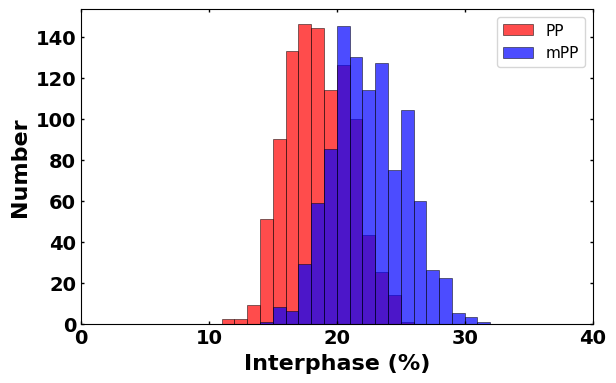

In [53]:
fig, ax = plt.subplots(figsize=(6.6,4.08))
y1 = data1['Intermediate Phase(%)']
y2 = data2['Intermediate Phase(%)']


ax.hist(y2,np.arange(0, 101, 1), label='PP',rwidth=1,
        alpha=0.7,edgecolor = "k", color = 'r',linewidth=0.5)
ax.hist(y1,np.arange(0, 101, 1), label='mPP',rwidth=1,
        alpha=0.7,edgecolor = "k", color ='b',linewidth=0.5)
ax.set_xlabel('Interphase (%)',fontsize=16, weight='bold')
ax.set_ylabel('Number', fontsize=16, weight='bold')
ax.tick_params(axis="x",direction="in", top=True,length=2, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=2, width=1)
plt.xticks(np.arange(0, 101, 10))
plt.xticks(fontsize=14,weight='bold')
plt.yticks(fontsize=14,weight='bold')
ax.legend(loc='upper right',shadow=False,prop={'size':11})
plt.xlim(0, 40)